# Tensorflow for RNN

In [1]:
# load library
import os

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

import tensorflow as tf

PROJECT_ROOT_DIR = "."
ID = "rnn"

In [2]:
# save figures
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

## Basic RNNs

### 1 Manual RNN

In [4]:
# unroll RNN manually
n_inputs = 3
n_units = 5

x0 = tf.placeholder(tf.float32, [None, n_inputs])
x1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal([n_inputs, n_units], dtype=tf.float32), name="Wx")
Wh = tf.Variable(tf.random_normal([n_units, n_units], dtype=tf.float32), name="Wh")
b = tf.Variable(tf.zeros([n_units,], dtype=tf.float32), name="b")

h0 = tf.tanh(tf.matmul(x0, Wx) + b)
h1 = tf.tanh(tf.matmul(x1, Wx) + tf.matmul(h0, Wh) + b)

init = tf.global_variables_initializer()

In [5]:
x0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
x1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    sess.run(init)
    h0_val, h1_val = sess.run([h0, h1], feed_dict={x0: x0_batch, x1: x1_batch})

In [6]:
print(h0_val)

[[-0.33335388 -0.99984092  0.96257252  0.99972427  0.34358242]
 [-0.34939748 -1.         -0.6466651   1.         -0.86954355]
 [-0.36523882 -1.         -0.9982453   1.         -0.9952535 ]
 [ 0.99999756 -1.         -1.          0.99948496 -1.        ]]


In [7]:
print(h1_val)

[[ 0.914249   -1.         -0.99999714  1.         -0.9999699 ]
 [ 0.91388243  0.82330334  0.99997503 -0.54982889  0.68797135]
 [ 0.96552432 -1.         -0.87868202  1.         -0.99206823]
 [ 0.98695272 -0.99991322  0.59633946  0.99998528 -0.40242517]]


### Using ```rnn()```

In [10]:
# static unroll RNN
tf.reset_default_graph()

batch_size = 4

x0 = tf.placeholder(tf.float32, [None, n_inputs])
x1 = tf.placeholder(tf.float32, [None, n_inputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units)
init_state = cell.zero_state(batch_size, dtype=tf.float32)
outputs, states = tf.contrib.rnn.static_rnn(cell, [x0, x1], initial_state=init_state)

h0, h1 = outputs

init = tf.global_variables_initializer()

In [11]:
x0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
x1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    sess.run(init)
    h0_val, h1_val = sess.run([h0, h1], feed_dict={x0: x0_batch, x1: x1_batch})

In [12]:
print(h0_val)

[[-0.84075469 -0.24504103 -0.47801617 -0.81902725  0.27693051]
 [-0.88173866 -0.97021145 -0.63182706 -0.99945551  0.99449092]
 [-0.91267502 -0.99924624 -0.74804145 -0.99999863  0.999973  ]
 [ 0.99996418 -0.99994028  0.99749142 -0.99956077  0.99995661]]


In [13]:
print(h1_val)

[[ 0.74716586 -0.99994993  0.2154983  -0.99999934  0.99999976]
 [ 0.17931944  0.33916888  0.8354494   0.44775939  0.86307251]
 [ 0.79777038 -0.99551833  0.86567175 -0.99961263  0.9999947 ]
 [ 0.08692072 -0.97432131  0.91839492 -0.9430967   0.99913162]]


### Packing sequences

In [14]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_units = 5

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
x_seq = tf.unstack(x, num=n_steps, axis=1)

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units)
init_state = cell.zero_state(batch_size, dtype=tf.float32)
outputs, states = tf.contrib.rnn.static_rnn(cell, x_seq, initial_state=init_state)

init = tf.global_variables_initializer()

In [16]:
x_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    sess.run(init)
    outputs_val = sess.run(outputs,feed_dict={x: x_batch})

In [17]:
print(outputs_val[1])

[[-0.06258702  1.          0.90452164 -0.99995655 -0.99997294]
 [-0.70032823  0.37023115 -0.01365535  0.36493999 -0.32459897]
 [-0.62021768  0.99998254  0.39824897 -0.99698222 -0.99930936]
 [ 0.31216088  0.99843973 -0.80233294 -0.98409343 -0.80607212]]


In [18]:
print(outputs_val)

[array([[-0.11966424,  0.6925894 ,  0.62398833,  0.17242405, -0.11511036],
       [-0.07815791,  0.99931848,  0.86040169, -0.91863692, -0.96123236],
       [-0.03637883,  0.99999869,  0.95251852, -0.99746436, -0.99901563],
       [ 0.5348652 ,  0.99992323, -0.999354  , -0.99938959, -0.98840386]], dtype=float32), array([[-0.06258702,  1.        ,  0.90452164, -0.99995655, -0.99997294],
       [-0.70032823,  0.37023115, -0.01365535,  0.36493999, -0.32459897],
       [-0.62021768,  0.99998254,  0.39824897, -0.99698222, -0.99930936],
       [ 0.31216088,  0.99843973, -0.80233294, -0.98409343, -0.80607212]], dtype=float32)]


### Dyanmic unroll rnn

In [20]:
# a clean code
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_units = 5
batch_size = 4

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units)
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

init = tf.global_variables_initializer()

In [21]:
x_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    sess.run(init)
    outputs_val = sess.run(outputs,feed_dict={x: x_batch})

In [22]:
print(outputs_val)

[[[-0.78515506 -0.43593025 -0.60911769 -0.17927292 -0.7393747 ]
  [-0.99946702 -0.77885062 -0.99999893  0.99999279 -0.99988854]]

 [[-0.99369079 -0.81377232 -0.99814647  0.91571909 -0.99286312]
  [ 0.03580528  0.68118596  0.82371414  0.70241606 -0.66689587]]

 [[-0.99983364 -0.94772995 -0.99999297  0.99730957 -0.99982893]
  [-0.98845702 -0.08552338 -0.99856955  0.99975467 -0.99876517]]

 [[ 0.81873059 -0.87313306 -0.97621185  0.99987423  0.58628058]
  [-0.8284685  -0.19498895 -0.66734689  0.93472785 -0.98051625]]]


### Setting the sequence lengths

In [24]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_units = 5

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_len = tf.placeholder(tf.int32, [None,])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units)
outputs, states = tf.nn.dynamic_rnn(cell, x, sequence_length=seq_len, dtype=tf.float32)

init = tf.global_variables_initializer()

In [27]:
x_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    sess.run(init)
    outputs_val, states_val = sess.run([outputs, states], feed_dict={x: x_batch, seq_len: seq_length_batch})

In [28]:
print(outputs_val)

[[[-0.41555673  0.3124592  -0.70823008 -0.33731124 -0.89362472]
  [ 0.98357052  0.99992394 -0.99998671 -0.96938699 -1.        ]]

 [[ 0.04224264  0.96577072 -0.99503732 -0.81168658 -0.99997842]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.48296547  0.99884307 -0.99992758 -0.95732415 -1.        ]
  [ 0.94608235  0.9987244  -0.99961239 -0.94665825 -0.99997342]]

 [[ 0.99636436  0.93347925 -0.99988347 -0.69118667 -0.99979246]
  [ 0.80112863  0.94465852 -0.97441888 -0.78073817 -0.8295415 ]]]


In [29]:
print(states_val)

[[ 0.98357052  0.99992394 -0.99998671 -0.96938699 -1.        ]
 [ 0.04224264  0.96577072 -0.99503732 -0.81168658 -0.99997842]
 [ 0.94608235  0.9987244  -0.99961239 -0.94665825 -0.99997342]
 [ 0.80112863  0.94465852 -0.97441888 -0.78073817 -0.8295415 ]]


### Training a sequence classifier

In [31]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_units = 150
n_outputs = 10

learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None,])

with tf.variable_scope("rnn", initializer=tf.contrib.layers.variance_scaling_initializer()):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
    
logits = tf.layers.dense(states, n_outputs)  # fully connected layer
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(entropy)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [32]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [34]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for itr in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(train_op, feed_dict={x: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={x: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.933333 Test accuracy: 0.9163
1 Train accuracy: 0.946667 Test accuracy: 0.9475
2 Train accuracy: 0.953333 Test accuracy: 0.9582
3 Train accuracy: 0.953333 Test accuracy: 0.963
4 Train accuracy: 0.96 Test accuracy: 0.9679
5 Train accuracy: 0.973333 Test accuracy: 0.9625
6 Train accuracy: 0.946667 Test accuracy: 0.9682
7 Train accuracy: 0.96 Test accuracy: 0.9657
8 Train accuracy: 0.966667 Test accuracy: 0.97
9 Train accuracy: 0.993333 Test accuracy: 0.9764
10 Train accuracy: 0.966667 Test accuracy: 0.9669
11 Train accuracy: 0.98 Test accuracy: 0.9727
12 Train accuracy: 0.973333 Test accuracy: 0.966
13 Train accuracy: 0.953333 Test accuracy: 0.97
14 Train accuracy: 0.986667 Test accuracy: 0.9769
15 Train accuracy: 0.986667 Test accuracy: 0.9794
16 Train accuracy: 0.993333 Test accuracy: 0.9767
17 Train accuracy: 0.986667 Test accuracy: 0.9761
18 Train accuracy: 0.973333 Test accuracy: 0.9773
19 Train accuracy: 0.973333 Test accuracy: 0.9766
20 Train accuracy: 0.98 Test

### Multi-layer RNN

In [41]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_units1 = 150
n_units2 = 100
n_outputs= 10

batch_size = 150

learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None,])

basic_cell1 = tf.contrib.rnn.BasicRNNCell(num_units=n_units1, activation=tf.nn.relu)
basic_cell2 = tf.contrib.rnn.BasicRNNCell(num_units=n_units2, activation=tf.nn.relu)
cell = tf.contrib.rnn.MultiRNNCell([basic_cell1, basic_cell2])

outputs, states_tuple = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

states = tf.concat(values=states_tuple, axis=1)
logits = tf.layers.dense(states, n_outputs)

entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(entropy)

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [42]:
n_epochs = 100

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for itr in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(train_op, feed_dict={x: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={x: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.933333 Test accuracy: 0.9364
1 Train accuracy: 0.966667 Test accuracy: 0.9673
2 Train accuracy: 0.98 Test accuracy: 0.9724
3 Train accuracy: 0.986667 Test accuracy: 0.9749
4 Train accuracy: 0.986667 Test accuracy: 0.9749
5 Train accuracy: 0.96 Test accuracy: 0.9754
6 Train accuracy: 0.993333 Test accuracy: 0.9733
7 Train accuracy: 0.993333 Test accuracy: 0.9744
8 Train accuracy: 1.0 Test accuracy: 0.9744
9 Train accuracy: 0.98 Test accuracy: 0.9791
10 Train accuracy: 1.0 Test accuracy: 0.9782
11 Train accuracy: 1.0 Test accuracy: 0.9765
12 Train accuracy: 1.0 Test accuracy: 0.9827
13 Train accuracy: 0.993333 Test accuracy: 0.9757
14 Train accuracy: 0.993333 Test accuracy: 0.9798
15 Train accuracy: 0.993333 Test accuracy: 0.9773
16 Train accuracy: 0.986667 Test accuracy: 0.9812
17 Train accuracy: 0.993333 Test accuracy: 0.9848
18 Train accuracy: 0.993333 Test accuracy: 0.9814
19 Train accuracy: 0.993333 Test accuracy: 0.9765
20 Train accuracy: 0.993333 Test accuracy:

### Time series

In [44]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t * 5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0, n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

d:\anaconda3\envs\tf_new\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Saving figure time_series_plot


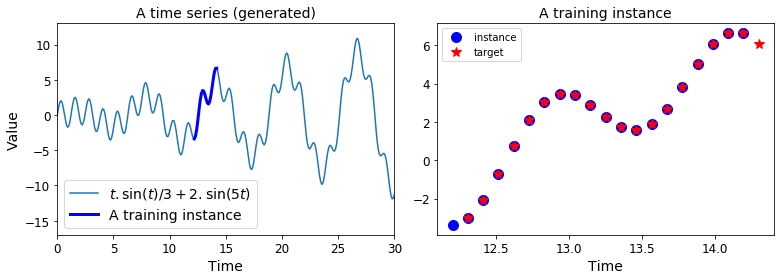

In [49]:
t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [50]:
X_batch, y_batch = next_batch(1, n_steps)

In [51]:
np.c_[X_batch[0], y_batch[0]]

array([[-3.40105091, -3.1535112 ],
       [-3.1535112 , -2.4019374 ],
       [-2.4019374 , -1.23833849],
       [-1.23833849,  0.14769251],
       [ 0.14769251,  1.51446705],
       [ 1.51446705,  2.6264053 ],
       [ 2.6264053 ,  3.31071511],
       [ 3.31071511,  3.49867895],
       [ 3.49867895,  3.2414507 ],
       [ 3.2414507 ,  2.69650536],
       [ 2.69650536,  2.08807012],
       [ 2.08807012,  1.65123531],
       [ 1.65123531,  1.57343979],
       [ 1.57343979,  1.94766747],
       [ 1.94766747,  2.74882441],
       [ 2.74882441,  3.83908994],
       [ 3.83908994,  5.00094079],
       [ 5.00094079,  5.98977144],
       [ 5.98977144,  6.59323507],
       [ 6.59323507,  6.68278338]])

### Using ```OutputProjectionWrapper()```

In [52]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_units = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_units,
                activation=tf.nn.relu), output_size = n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_sum(tf.square(outputs - y))
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

In [53]:
n_epochs = 1000
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "MSE", mse)
    
    X_new = time_series(t_instance[:-1].reshape(-1, n_steps, n_inputs))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(X_new)
    print(y_pred)

Epoch 0 MSE 16805.7
Epoch 100 MSE 478.19
Epoch 200 MSE 197.619
Epoch 300 MSE 134.71
Epoch 400 MSE 96.4492
Epoch 500 MSE 64.9992
Epoch 600 MSE 61.2047
Epoch 700 MSE 50.3473
Epoch 800 MSE 61.2037
Epoch 900 MSE 47.3403
[[[-3.38903462]
  [-2.99062806]
  [-2.05341138]
  [-0.72228309]
  [ 0.75538291]
  [ 2.09516406]
  [ 3.05094764]
  [ 3.47993654]
  [ 3.37980751]
  [ 2.88802793]
  [ 2.24353023]
  [ 1.7210823 ]
  [ 1.55604639]
  [ 1.87980783]
  [ 2.68328027]
  [ 3.81833127]
  [ 5.03675731]
  [ 6.05632222]
  [ 6.63608254]
  [ 6.64072041]]]
[[[-3.51775551]
  [-2.53501797]
  [-1.15251982]
  [ 0.60017455]
  [ 1.98542166]
  [ 3.06789064]
  [ 3.54276776]
  [ 3.362077  ]
  [ 2.93283987]
  [ 2.11475372]
  [ 1.56365407]
  [ 1.45852852]
  [ 1.86208022]
  [ 2.68589473]
  [ 3.81468797]
  [ 5.01798582]
  [ 6.01481771]
  [ 6.61353302]
  [ 6.57810783]
  [ 5.983284  ]]]


Saving figure time_series_pred_plot


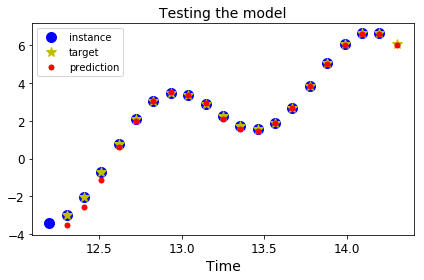

In [55]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

### Without using ```OutputProjectionWrapper```

In [59]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_units = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_units, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_units])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_sum(tf.square(outputs - y))
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

In [60]:
n_epochs = 1000
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "MSE", mse)
    
    X_new = time_series(t_instance[:-1].reshape(-1, n_steps, n_inputs))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(X_new)
    print(y_pred)

Epoch 0 MSE 12681.7
Epoch 100 MSE 611.424
Epoch 200 MSE 208.967
Epoch 300 MSE 103.201
Epoch 400 MSE 62.355
Epoch 500 MSE 63.4591
Epoch 600 MSE 56.7102
Epoch 700 MSE 58.3863
Epoch 800 MSE 44.6704
Epoch 900 MSE 52.3096
[[[-3.38903462]
  [-2.99062806]
  [-2.05341138]
  [-0.72228309]
  [ 0.75538291]
  [ 2.09516406]
  [ 3.05094764]
  [ 3.47993654]
  [ 3.37980751]
  [ 2.88802793]
  [ 2.24353023]
  [ 1.7210823 ]
  [ 1.55604639]
  [ 1.87980783]
  [ 2.68328027]
  [ 3.81833127]
  [ 5.03675731]
  [ 6.05632222]
  [ 6.63608254]
  [ 6.64072041]]]
[[[-3.47104859]
  [-2.4952054 ]
  [-1.26815391]
  [ 0.67656517]
  [ 2.2081449 ]
  [ 3.09208822]
  [ 3.49673343]
  [ 3.3366437 ]
  [ 2.9629519 ]
  [ 2.18085527]
  [ 1.61444068]
  [ 1.49737442]
  [ 1.92812812]
  [ 2.77589178]
  [ 3.92481685]
  [ 5.14265347]
  [ 6.1297102 ]
  [ 6.67620325]
  [ 6.68489265]
  [ 6.13003349]]]


Saving figure time_series_pred_plot


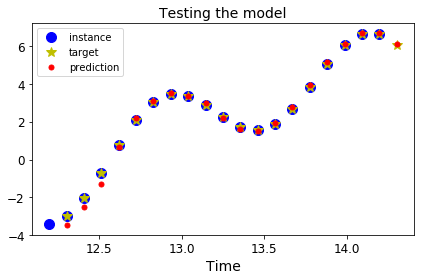

In [61]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

### Generating new sequence

Epoch 0 MSE 18461.4
Epoch 100 MSE 775.334
Epoch 200 MSE 183.63
Epoch 300 MSE 86.1643
Epoch 400 MSE 62.2201
Epoch 500 MSE 55.894
Epoch 600 MSE 51.0927
Epoch 700 MSE 52.7136
Epoch 800 MSE 56.0478
Epoch 900 MSE 42.1387
Epoch 1000 MSE 57.3633
Epoch 1100 MSE 47.4708
Epoch 1200 MSE 50.8996
Epoch 1300 MSE 53.1064
Epoch 1400 MSE 44.7769
Saving figure creative_sequence_plot


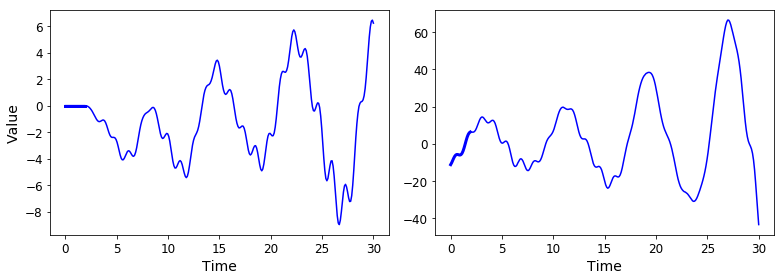

In [69]:
n_epochs = 1500
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    # train
    for epoch in range(n_epochs):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "MSE", mse)
    
    # generate
    seq1 = [0.0 for i in range(n_steps)]
    for itr in range(len(t) - n_steps):
        X_batch = np.array(seq1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        seq1.append(y_pred[0, -1, 0])
    
    seq2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for itr in range(len(t) - n_steps):
        X_batch = np.array(seq2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        seq2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, seq1, "b-")
plt.plot(t[:n_steps], seq1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, seq2, "b-")
plt.plot(t[:n_steps], seq2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

## Deep RNN
### MultiRNNCell

In [75]:
tf.reset_default_graph()

n_inputs = 2
n_units = 100
n_rnn_layers = 3
n_steps = 5
keep_prob = 0.5

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_units) for _ in range(n_rnn_layers)])
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

init = tf.global_variables_initializer()

In [76]:
X_batch = np.random.rand(2, n_steps, n_inputs)
with tf.Session() as sess:
    sess.run(init)
    outputs_val, states_val = sess.run([outputs, states], feed_dict={x: X_batch})

In [77]:
print(outputs_val.shape)

(2, 5, 100)


In [78]:
print(len(states_val))

3


### Dropout

In [89]:
tf.reset_default_graph()

n_inputs = 1
n_units = 100
n_rnn_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.8
learning_rate = 0.001

def model(X, y, is_training=True):
    if is_training:
        cell_list = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_units,), input_keep_prob=keep_prob)
                      for _ in range(n_rnn_layers)]
    else:
        cell_list = [tf.contrib.rnn.BasicRNNCell(num_units=n_units, reuse= not is_training) for _ in range(n_rnn_layers)]
          
    cell = tf.contrib.rnn.MultiRNNCell(cell_list)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_units])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    
    loss = tf.reduce_sum(tf.square(outputs - y))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return outputs, loss, train_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
with tf.variable_scope("model", reuse=False):
    t_outputs, loss, train_op = model(X, y)

with tf.variable_scope("model", reuse=True):
    v_outputs, _, _ = model(X, y, is_training=False)

init = tf.global_variables_initializer()

Epoch 0 MSE 28683.9
Epoch 100 MSE 5585.86
Epoch 200 MSE 4104.79
Epoch 300 MSE 2766.7
Epoch 400 MSE 2305.93
Epoch 500 MSE 2710.83
Epoch 600 MSE 1676.19
Epoch 700 MSE 1735.69
Epoch 800 MSE 1576.85
Epoch 900 MSE 2018.53
Epoch 1000 MSE 1770.96
Epoch 1100 MSE 1533.56
Epoch 1200 MSE 1374.3
Epoch 1300 MSE 1624.88
Epoch 1400 MSE 1252.66
Epoch 1500 MSE 1321.51
Epoch 1600 MSE 1600.19
Epoch 1700 MSE 1381.51
Epoch 1800 MSE 1419.25
Epoch 1900 MSE 1292.31


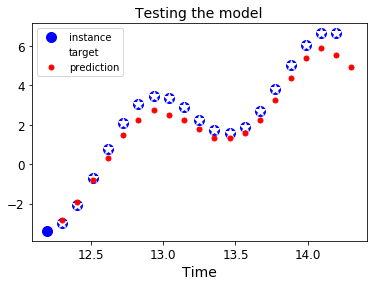

In [90]:
n_epochs = 2000
batch_size = 128

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "MSE", mse)
    
    # Test
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(v_outputs, feed_dict={X: X_new})
        
    plt.title("Testing the model", fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.show()

In [106]:
tf.reset_default_graph()

n_inputs = 1
n_units = 100
n_rnn_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

def model(X, y, keep_prob_t):
    
    cell_list = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_units,), input_keep_prob=keep_prob_t)
                      for _ in range(n_rnn_layers)]
    
    cell = tf.contrib.rnn.MultiRNNCell(cell_list)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_units])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    
    loss = tf.reduce_sum(tf.square(outputs - y))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return outputs, loss, train_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
keep_prob_t = tf.placeholder(tf.float32)

outputs, loss, train_op = model(X, y, keep_prob_t)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Epoch 0 MSE 16760.1
Epoch 100 MSE 4765.84
Epoch 200 MSE 3794.69
Epoch 300 MSE 3385.63
Epoch 400 MSE 4468.75
Epoch 500 MSE 3069.24
Epoch 600 MSE 2526.14
Epoch 700 MSE 2431.3
Epoch 800 MSE 1855.84
Epoch 900 MSE 2820.45
Epoch 1000 MSE 3579.5
Epoch 1100 MSE 2346.72
Epoch 1200 MSE 2487.6
Epoch 1300 MSE 2309.52
Epoch 1400 MSE 2915.64
Epoch 1500 MSE 2728.46
Epoch 1600 MSE 2031.27
Epoch 1700 MSE 1942.66
Epoch 1800 MSE 2280.94
Epoch 1900 MSE 2746.33


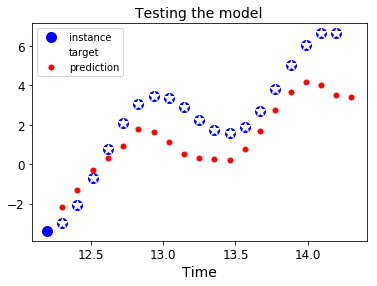

In [107]:
n_epochs = 2000
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: X_batch, y: y_batch, keep_prob_t: keep_prob})
        if epoch % 100 == 0:
            mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch, keep_prob_t: keep_prob})
            print("Epoch", epoch, "MSE", mse)
    # Test
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new, keep_prob_t: 1.0})
        
    plt.title("Testing the model", fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.show()

### LSTM

In [109]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_units = 150
n_outputs = 10
n_lstm_layers = 3

learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None,])

with tf.variable_scope("LSTM", initializer=tf.contrib.layers.variance_scaling_initializer()):
    cell_list = [tf.contrib.rnn.BasicLSTMCell(num_units=n_units, forget_bias=0.0) for _ in range(n_lstm_layers)]
    cell = tf.contrib.rnn.MultiRNNCell(cell_list)
    outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
    
top_lstm_layer_h = states[-1][1]

logits = tf.layers.dense(top_lstm_layer_h, n_outputs)  # fully connected layer
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(entropy)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [110]:
print(states)

(LSTMStateTuple(c=<tf.Tensor 'LSTM/rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'LSTM/rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'LSTM/rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'LSTM/rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'LSTM/rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'LSTM/rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))


In [111]:
print(top_lstm_layer_h)

Tensor("LSTM/rnn/while/Exit_7:0", shape=(?, 150), dtype=float32)


In [112]:
n_epochs = 20

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for itr in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(train_op, feed_dict={x: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={x: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.98 Test accuracy: 0.9404
1 Train accuracy: 1.0 Test accuracy: 0.9815
2 Train accuracy: 1.0 Test accuracy: 0.978
3 Train accuracy: 1.0 Test accuracy: 0.9804
4 Train accuracy: 1.0 Test accuracy: 0.9801
5 Train accuracy: 1.0 Test accuracy: 0.9895
6 Train accuracy: 1.0 Test accuracy: 0.9839
7 Train accuracy: 1.0 Test accuracy: 0.9886
8 Train accuracy: 1.0 Test accuracy: 0.9907
9 Train accuracy: 1.0 Test accuracy: 0.9859
10 Train accuracy: 1.0 Test accuracy: 0.9914
11 Train accuracy: 0.98 Test accuracy: 0.9888
12 Train accuracy: 1.0 Test accuracy: 0.9839
13 Train accuracy: 1.0 Test accuracy: 0.99
14 Train accuracy: 1.0 Test accuracy: 0.9881
15 Train accuracy: 1.0 Test accuracy: 0.9887
16 Train accuracy: 1.0 Test accuracy: 0.9894
17 Train accuracy: 1.0 Test accuracy: 0.9906
18 Train accuracy: 1.0 Test accuracy: 0.9915
19 Train accuracy: 1.0 Test accuracy: 0.9868


### Distributing layers across devices

In [113]:
# the implemention of tf.contrib.rnn.DeviceWrapper
class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device
    
    @property
    def state_size(self):
        return self._cell.state_size
    
    @property
    def output_size(self):
        return self._cell.output_size
    
    def zero_state(self, batch_size, dtype=tf.float32):
        with tf.name_scope(type(self).__name__ + "ZeroState", values=[batch_size]):
            return self._cell.zero_state(batch_size, dtype)
    
    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope=scope)

In [114]:
tf.reset_default_graph()

n_inputs = 5
n_units = 100
devices = ["/cpu:0"] * 5
n_steps = 20

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(d, tf.contrib.rnn.BasicLSTMCell(num_units=n_units))
               for d in devices]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

init = tf.global_variables_initializer()

In [120]:
with tf.Session() as sess:
    sess.run(init)
    o, s = sess.run([outputs, states], feed_dict={x: np.random.rand(2, n_steps, n_inputs)})
    print(o.shape)
    print(o)
    print(len(s))
    print(s[-1][-1].shape)

(2, 20, 100)
[[[  1.10517049e-05  -3.39324652e-06   1.88815375e-06 ...,   2.07342018e-05
     3.01883642e-06  -2.07689263e-05]
  [  3.81280479e-05  -1.45351160e-05   6.74469720e-06 ...,   8.08613331e-05
     1.27205421e-05  -8.34117818e-05]
  [  8.20077476e-05  -3.77131146e-05   1.54183545e-05 ...,   1.95936620e-04
     3.81563914e-05  -2.11727267e-04]
  ..., 
  [ -2.00475683e-03   5.37709100e-04   1.62039138e-03 ...,   1.68269128e-03
     8.14274128e-04  -6.40866486e-03]
  [ -2.47456320e-03   1.01784908e-03   1.95362838e-03 ...,   1.44464616e-03
     3.96985182e-04  -6.36696117e-03]
  [ -2.93949479e-03   1.55080645e-03   2.30732700e-03 ...,   1.21466152e-03
    -9.47825174e-05  -6.24832604e-03]]

 [[  1.12432090e-05   8.80935374e-07   5.98191309e-06 ...,   1.70006078e-05
    -3.92921083e-06  -8.98602048e-06]
  [  4.35743132e-05   4.29972516e-07   2.38444045e-05 ...,   8.29850906e-05
    -1.44983460e-05  -4.59686889e-05]
  [  9.71345289e-05  -8.25025108e-06   5.86029855e-05 ...,   2.20

## Embeddings

### Get the data

In [121]:
import urllib.request
import zipfile
import os

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [122]:
words = fetch_words_data()

In [123]:
print(words[:5])

['anarchism', 'originated', 'as', 'a', 'term']


### Bulid the dictionary

In [124]:
from collections import Counter

vocb_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocb_size - 1)
vocabulary = np.array([w for w, _ in vocabulary])
word_to_idx = {w: id for id, w in enumerate(vocabulary)}
data = np.array([word_to_idx.get(w, 0) for w in words])

In [128]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [127]:
print(len(data), len(word_to_idx))

17005207 50000


In [129]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [130]:
words[24], data[24]

('culottes', 0)

### Generate batch

In [131]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [132]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [133]:
print(batch, [vocabulary[idx] for idx in batch])

[3081 3081   12   12    6    6  195  195] ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']


In [135]:
print(labels, [vocabulary[idx] for idx in labels[:, 0]])

[[  12]
 [5234]
 [   6]
 [3081]
 [  12]
 [ 195]
 [   6]
 [   2]] ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']


### Build the model

In [136]:
batch_size = 128
embedding_size = 128  # dimension of the embedding vector
skip_window = 1       # how many words to consider left and right
num_skips = 2         # how many times to reuse an input to generate a label

# validation set
valid_size = 16       # Random set of words to evaluate similarity on
valid_window = 100    # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_sampled = 64   # Number of negative examples to sample.

learning_rate = 0.01

In [141]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
init_embeddings = tf.random_uniform([vocb_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocb_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocb_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocb_size))

# Construct the Adam optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [144]:
num_steps = 10001

with tf.Session() as sess:
    sess.run(init)

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([train_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  314.16708374
Nearest to its: tbs, durham, monographs, increased, giles, elevations, spotted, conciliation,
Nearest to are: killed, grappling, message, idealists, stamps, lighters, counterbalanced, enya,
Nearest to zero: trunks, buzz, gangrene, intrusions, fishing, dealing, orchard, obtains,
Nearest to time: freedoms, casual, keralite, karenina, pouring, blogger, subgroup, disappeared,
Nearest to b: hay, reagan, ligny, columbian, cripps, beja, asking, lancers,
Nearest to united: destruction, watches, were, filmfare, earthly, strived, kaolinite, discharges,
Nearest to new: ciphertexts, kwajalein, maccabees, abba, calculated, impaired, joked, loxodonta,
Nearest to than: cen, say, boca, rms, discusses, tilt, wasn, trailed,
Nearest to about: swell, peninsulas, zaghawa, predication, fragments, cries, lombards, reliable,
Nearest to s: molecular, rhymes, housework, incubation, wr, perform, certificates, tirelessly,
Nearest to all: malleus, asiatic, finan

In [145]:
np.save("./my_final_embeddings.npy", final_embeddings)

### Plot the embeddings

In [150]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig("./1.png",format="png", dpi=300)

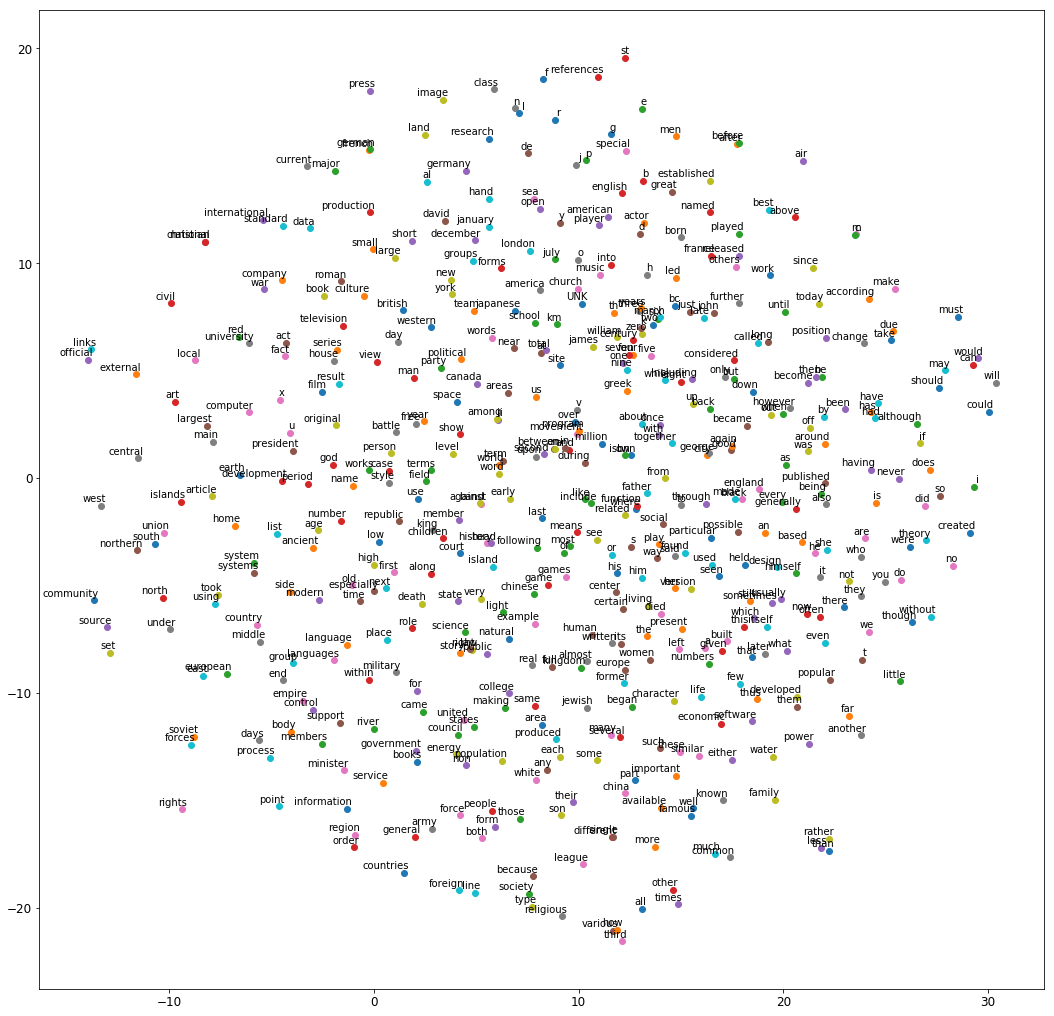

In [151]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
